In [6]:


import numpy as np
import pandas as pd
from debiasm.sklearn_functions import AdaptationDebiasMClassifier, DebiasMClassifier
from debiasm.torch_functions import rescale
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
import torch
import sys
sys.path.append('../v1-DEBIAS-M-Analysis/General_functions/')
import plotting



def experiment_run(samples_,
                   n_studies, 
                   n_per_study,
                   n_features,
                   phenotype_std,
                   read_depth, 
                   bcf_stdv = 2, 
                   linear_weights_stdv = 2,
                   rd_mean=None,
                   seed=0
                   ):
    
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    
    # drop samples/features not needed for this run
    samples=samples_.sample(n=n_studies * n_per_study, 
                           replace=False)\
                .T.sample(n=n_features, replace=False).T
    
    ## simulated bcfs
    true_bcfs = np.random.normal(scale=bcf_stdv,
                                 size = (n_studies, n_features)
                                 )
    
    ## simulated linear weights
    true_weights = np.random.normal(scale=linear_weights_stdv, 
                                    size = n_features
                                    )

    ## simulated phenotypes
    phenotypes = samples @ true_weights[:, np.newaxis]
    if phenotype_std > 0:
        phenotypes += np.random.normal(scale = phenotype_std,
                                       size=phenotypes.shape)
    
    studies = pd.Series( [ i // n_per_study for i in range(samples.shape[0]) 
                                     ] , 
                        index=samples.index, 
                        name='studies')

    samples_transformed = ( rescale( samples *\
                                    np.power(2, true_bcfs)[studies] 
                                    )*read_depth
                              ).astype(int)

    test_set_inds = studies==studies.max()
    train_set_inds = studies!=studies.max()
    
    phenotypes = phenotypes.loc[train_set_inds]
    df_with_batch = pd.concat([studies, samples_transformed], axis=1 )
    
    dm = DebiasMClassifier(x_val = df_with_batch.loc[test_set_inds].values)
    dm.fit(X=df_with_batch.loc[train_set_inds].values, 
           y=phenotypes.values[:, 0] > phenotypes.median().values[0]    
          )
    
    transformed_jsds = jensenshannon(dm.transform(pd.concat([studies,
                                      samples_transformed], 
                                     axis=1 )
                          ).T,
              samples.T)

    baseline_jsds = jensenshannon(samples_transformed.T, samples.T)
    n_samples = samples.shape[0]

    if type( read_depth ) == np.ndarray:
        read_depth=rd_mean
        
    if type(bcf_stdv)==np.ndarray:
        bcf_stdv='varied'
        
    
    
    summary_df = pd.DataFrame({'Group':['Baseline']*n_samples +\
                                               ['DEBIAS-M']*n_samples,
                               'JSD':list(baseline_jsds**2) +\
                                           list(transformed_jsds**2),
                               'N_studies':n_studies, 
                               'N_per_study':n_per_study, 
                               'N_features':n_features, 
                               'Pheno_noise':phenotype_std, 
                               'Read_depth':read_depth, 
                               'BCF_std':bcf_stdv,
                               'is_test_set':list(test_set_inds.values)*2,
                               'run_num':seed
                              })
    
    run_description = '_'.join( [a.replace('_', '-') + '-' + str(b)
                                 for a,b in 
                                   {'N_studies':n_studies, 
                                   'N_per_study':n_per_study, 
                                   'N_features':n_features, 
                                   'Pheno_noise':phenotype_std, 
                                   'Read_depth':int(read_depth), 
                                   'BCF_std':bcf_stdv,
                                   'run_num':seed}.items()]
                                )
    return(summary_df, run_description, true_bcfs, dm)



In [7]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [8]:
all_results_constant_within_batch = []
all_results_varying_within_batch = []

for n_features in [100]:
    for n_studies in [4]:
        for n_per_study in [96]:
            for phenotype_std in [0.1]:
                for read_depth_ in [1e3, 1e4, 1e5]:
                    for seed in range(1,26):
                        print(seed)
                        np.random.seed(seed)
                        
                        data = pd.read_csv('../Simulations/generated-100-feat-datasets//dataset-seed-{}.csv'.format(seed), 
                                              index_col=0)
                        
                        rd_mean=read_depth_
                        
                        per_study_means = np.random.lognormal(mean=np.log(read_depth_), size=n_studies)
                        
                        
                        read_depth = np.hstack([ np.array([a]*n_per_study)
                                     for a in per_study_means ] )[:, np.newaxis]
                        
                        
                        results, run_desc, true_bcfs, dm = \
                                            experiment_run(data,
                                                           n_studies, 
                                                           n_per_study,
                                                           n_features,
                                                           phenotype_std,
                                                           read_depth, 
                                                           bcf_stdv = 2, 
                                                           rd_mean=rd_mean,
                                                           seed=seed
                                                           )
                        
                
                        all_results_constant_within_batch.append(results)
                    
                    
                        np.random.seed(seed)
                        read_depth = np.hstack([ np.random.lognormal(mean = np.log(a),
                                                                     size=n_per_study)
                                     for a in per_study_means ] )[:, np.newaxis]
                    
                        results, run_desc, true_bcfs, dm = \
                                            experiment_run(data,
                                                           n_studies, 
                                                           n_per_study,
                                                           n_features,
                                                           phenotype_std,
                                                           read_depth, 
                                                           bcf_stdv = 2, 
                                                           rd_mean=rd_mean,
                                                           seed=seed
                                                           )
                        
                        all_results_varying_within_batch.append(results)

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider incre

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider incre

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

1


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

2


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

3


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

4


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

5


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

6


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

7


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future ve

8


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has 

9


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

10


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

11


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider incre

12


Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: 

13


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

14


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

15


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

16


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

17


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

18


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

19


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

20


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

21


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

22


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

23


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return(xx/xx.sum(axis=1)[:, np.newaxis] )
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pas

24


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

25


/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/debiasm/torch_functions.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = softmax(x)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of 

In [9]:
from scipy.stats import wilcoxon, mannwhitneyu
import itertools
alll=pd.concat([pd.concat(all_results_varying_within_batch)\
                           .assign(depth_method='varying'), 
               pd.concat(all_results_constant_within_batch)\
                           .assign(depth_method='constant')])

alll = alll.loc[ alll.is_test_set ]
import sys
sys.path.append('../v1-DEBIAS-M-Analysis/')
from General_functions.plotting import global_palette

alll['Depth method'] = alll.depth_method.str.capitalize()
alll['Group_'] = alll['Group'] + ' - ' + alll['Depth method']

   sig_v_debias  Read_depth     Group
0  1.490116e-07      1000.0  Baseline
1  8.940697e-08     10000.0  Baseline
2  1.490116e-07    100000.0  Baseline


DEBIAS-M Read_depth 1000.0 vs 10000.0 p: 1.7e-01
DEBIAS-M Read_depth 1000.0 vs 100000.0 p: 1.8e-01
DEBIAS-M Read_depth 10000.0 vs 100000.0 p: 4.7e-01


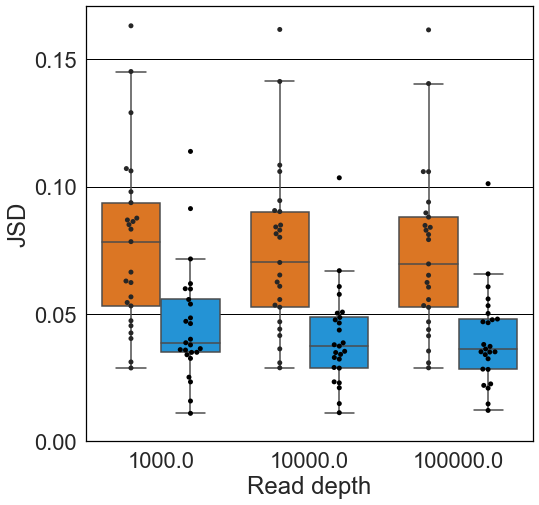

   sig_v_debias  Read_depth     Group
0  1.281500e-06      1000.0  Baseline
1  1.281500e-06     10000.0  Baseline
2  9.834766e-07    100000.0  Baseline


DEBIAS-M Read_depth 1000.0 vs 10000.0 p: 2.2e-01
DEBIAS-M Read_depth 1000.0 vs 100000.0 p: 1.7e-01
DEBIAS-M Read_depth 10000.0 vs 100000.0 p: 3.6e-01


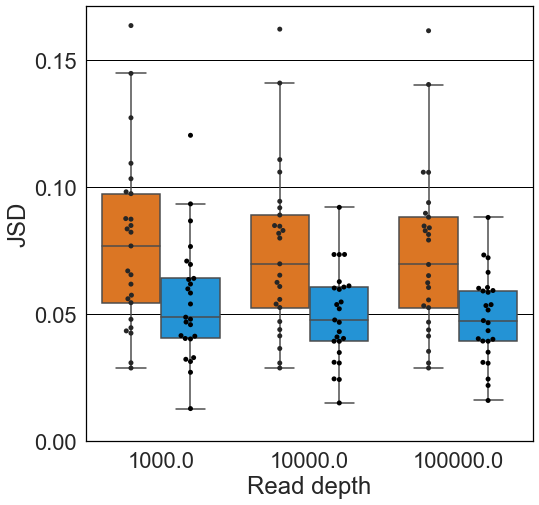

In [38]:
for dm_method in ['Constant', 'Varying']:
    plt.figure(figsize=(8,8))
    ax=sns.boxplot(x='Read_depth', 
                   hue='Group_',
                   y='JSD', 
                   data = alll.loc[alll['Depth method']==dm_method]\
                                   .groupby(['Group', 'N_studies', 'Read_depth', 
                                     'Depth method', 'run_num', 'Group_']
                    )['JSD'].median().reset_index(), 
                   palette={'Baseline - Constant':global_palette['linear'],
                            'DEBIAS-M - Constant':global_palette['debias-m'],
                            'Baseline - Varying':global_palette['linear'],
                            'DEBIAS-M - Varying':global_palette['debias-m'],
                           }, 
                   fliersize=0
                  )
    handles, labels = ax.get_legend_handles_labels()

    sns.swarmplot(x='Read_depth', 
                  hue='Group_',
                  y='JSD', 
                  data = alll.loc[alll['Depth method']==dm_method]\
                              .groupby(['Group', 'N_studies', 'Read_depth',
                                       'Depth method', 'run_num', 'Group_']
                    )['JSD'].median().reset_index(),
                  color='black',
                  ax=ax,
                  dodge=True,
                  s=5
                )
    
    plt.yticks([0, .05, .1, .15])
    plt.legend().remove()
    plt.xlabel('Read depth')
    
    plt.savefig('../results/Depth-varying-simulations/results-depth-{}.pdf'\
                                    .format(dm_method), 
               format='pdf', 
               bbox_inches='tight', 
               dpi=900)
    
    col_of_interest='Read_depth'
    
    df_tmp=alll.loc[alll['Depth method']==dm_method]\
                                   .groupby(['Group', 'N_studies', 'Read_depth', 
                                     'Depth method', 'run_num', 'Group_']
                    )['JSD'].median().reset_index()
    
    q = pd.DataFrame( {'sig_v_debias':  [ wilcoxon( df_tmp.loc[( df_tmp[col_of_interest] == a)&
                                     ( df_tmp['Group'] == 'Baseline' )].JSD, 
                            df_tmp.loc[( df_tmp[col_of_interest] == a)&
                                       ( df_tmp['Group'] == 'DEBIAS-M' )].JSD, 
                                     alternative='greater'
                          ).pvalue < 1e-3
                           for a in df_tmp[col_of_interest].unique() ], 
                         col_of_interest:df_tmp[col_of_interest].unique(), 
                       'Group':['Baseline'] * df_tmp[col_of_interest].nunique()
                            }
                    )

    

    print(pd.DataFrame( {'sig_v_debias':  [ wilcoxon( df_tmp.loc[( df_tmp[col_of_interest] == a)&
                                 ( df_tmp['Group'] == 'Baseline' )].JSD, 
                        df_tmp.loc[( df_tmp[col_of_interest] == a)&
                                   ( df_tmp['Group'] == 'DEBIAS-M' )].JSD, 
                                 alternative='greater'
                      ).pvalue
                       for a in df_tmp[col_of_interest].unique() ], 
                     col_of_interest:df_tmp[col_of_interest].unique(), 
                   'Group':['Baseline'] * df_tmp[col_of_interest].nunique()
                        }
                ))
    print('\n')
    for a,b in itertools.combinations(df_tmp[col_of_interest].unique(), 2):
        print('DEBIAS-M {} {} vs {} p: {:.1e}'.format(
                                        col_of_interest,
                                        a, 
                                        b,  
                    mannwhitneyu(df_tmp.loc[(df_tmp.Group=='DEBIAS-M')&\
                                      (df_tmp[col_of_interest]==a)].JSD, 
                           df_tmp.loc[(df_tmp.Group=='DEBIAS-M')&\
                                      (df_tmp[col_of_interest]==b)].JSD ).pvalue
             ))
    
    
    plt.show()

